# Window and custom features

In forecasting time series data, it can be useful to consider additional characteristics beyond just the lagged values. For instance, the moving average of the previous *n* values can help capture the trend in the series.

The `ForecasterAutoregCustom` and `ForecasterAutoregMultiSeriesCustom` classes are similar to `ForecasterAutoreg` and `ForecasterAutoregMultiSeries`, respectively, but they allow the user to define their own function for generating features.

To create a custom features, the user needs to write a function that takes a time series as input (a NumPy ndarray) and outputs another NumPy ndarray containing the predictors. The Forecaster parameters used to specify this function are `fun_predictors` and `window_size` and `name_predictors` (optional).

## Libraries

In [5]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## ForecasterAutoregCustom

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)


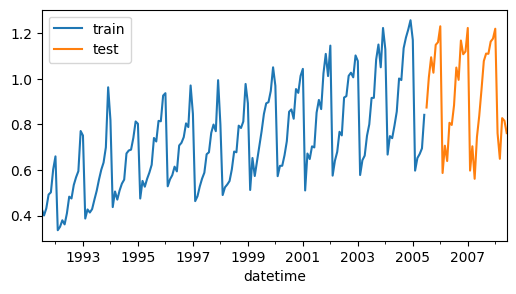

In [6]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
)

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

### Window and custom features

The following functions calculate some of the most commonly used window and custom features in time series forecasting:

+ Calculate the first 10 lags of the time series.

+ Calculate the moving average with a window of 20.

+ Calculate the moving standard deviation with a window of 20.

+ Calculate the moving minimum and maximum with a window of 20.

+ Exponential Moving Average (EMA) with a window of 20 for smoothing.

+ The difference between the last value and the moving average to capture recent trends compared to the longer term average.

In [20]:
# Custom function to create features
# ==============================================================================
def create_predictors(y):
    """
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    Calculate the moving standard deviation with window 20.
    Calculate moving minimum and maximum with window 20.
    Calculate exponential moving average with window 20.
    Calculate the difference between the last value and the moving average.
    """

    # Calculate lags
    lags = y[-1:-11:-1]  # window size needed = 10

    # Calculate moving average
    mean = np.mean(y[-20:])  # window size needed = 20

    # Calculate moving standard deviation
    std_dev = np.std(y[-20:])  # window size needed = 20

    # Calculate moving minimum and maximum
    min_val = np.min(y[-20:])
    max_val = np.max(y[-20:])

    # Calculate exponential moving average
    ema = np.mean(y[-20:] * np.exp(-np.linspace(1, 20, 20) / 20))

    # Calculate the difference between the last value and the moving average
    diff_mean = y[-1] - mean

    # Combine all predictors
    predictors = np.hstack([lags, mean, std_dev, min_val, max_val, ema, diff_mean])

    return predictors


feature_names = [f"lag {i}" for i in range(1, 11)] + [
    "moving_avg_20",
    "moving_std_20",
    "moving_min_20",
    "moving_max_20",
    "ema_20",
    "diff_mean",
]

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

The <code>window_size</code> parameter specifies the size of the data window that <code>fun_predictors</code> uses to generate each row of predictors. Choosing the appropriate value for this parameter is crucial to avoid losing data when constructing the training matrices. 
<br><br>
In this case, the <code>window_size</code> required by the <b>mean is the largest</b> (most restrictive), so <code>window_size = 20</code>.

</div>

### Train forecaster

In [8]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                 regressor       = RandomForestRegressor(random_state=123),
                 fun_predictors  = create_predictors,
                 name_predictors = feature_names,
                 window_size     = 20 # window_size needed by the mean is the most restrictive one
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: create_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-07-13 12:56:33 
Last fit date: 2024-07-13 12:56:34 
Skfor

### Prediction

In [9]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(3)

2005-07-01    0.939100
2005-08-01    0.971447
2005-09-01    1.042810
Freq: MS, Name: pred, dtype: float64

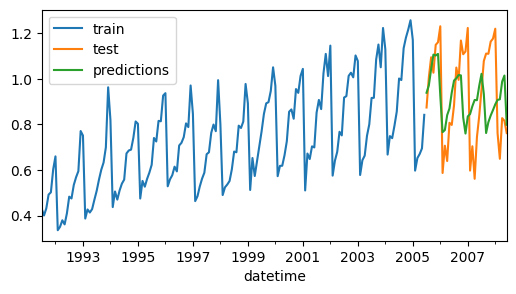

In [10]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [11]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.04358901250680434


### Feature importances

In [12]:
# Predictors importances
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
0,lag 1,0.516747
1,lag 2,0.103269
9,lag 10,0.092179
2,lag 3,0.044447
6,lag 7,0.040537
11,moving_std_20,0.035464
4,lag 5,0.030406
3,lag 4,0.024740
12,moving_min_20,0.023540
15,diff_mean,0.017996


### Extract training matrices

In [13]:
# Training matrix (X)
# ==============================================================================
X, y = forecaster.create_train_X_y(data_train)
X.head()

,lag 1,lag 2,lag 3,lag 4,lag 5,lag 6,lag 7,lag 8,lag 9,lag 10,moving_avg_20,moving_std_20,moving_min_20,moving_max_20,ema_20,diff_mean
datetime,,,,,,,,,,,,,,,,
1993-03-01,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.496401,0.124727,0.33622,0.771258,0.298062,-0.108846
1993-04-01,0.427283,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.496275,0.124796,0.33622,0.771258,0.299714,-0.068992
1993-05-01,0.413890,0.427283,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.496924,0.124331,0.33622,0.771258,0.302649,-0.083034
1993-06-01,0.428859,0.413890,0.427283,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.496759,0.124419,0.33622,0.771258,0.304446,-0.067900
1993-07-01,0.470126,0.428859,0.413890,0.427283,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.495638,0.124552,0.33622,0.771258,0.304076,-0.025512


In [14]:
# Target variable (y)
# ==============================================================================
y.head()

datetime
1993-03-01    0.427283
1993-04-01    0.413890
1993-05-01    0.428859
1993-06-01    0.470126
1993-07-01    0.509210
Freq: MS, Name: y, dtype: float64

### Differentiation

Time series differentiation involves computing the differences between consecutive observations in the time series. When it comes to training forecasting models, differentiation offers the advantage of focusing on relative rates of change rather than directly attempting to model the absolute values. Once the predictions have been estimated, this transformation can be easily reversed to restore the values to their original scale.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about modeling time series differentiation, visit our example: <a href="https://www.cienciadedatos.net/documentos/py49-modelling-time-series-trend-with-tree-based-models.html">Modelling time series trend with tree based models</a>.

</div>

In [15]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                 regressor       = RandomForestRegressor(random_state=123),
                 fun_predictors  = create_predictors,
                 name_predictors = feature_names,
                 window_size     = 20, # window_size needed by the mean is the most restrictive one
                 differentiation = 1
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: create_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-07-13 12:57:07 
Last fit date: 2024-07-13 12:57:10 
Skforeca

In [16]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)

2005-07-01    0.923317
2005-08-01    0.936214
2005-09-01    0.993153
Freq: MS, Name: pred, dtype: float64

## ForecasterAutoregMultiSeriesCustom

This Forecaster aims to model multiple time series simultaneously. It is based on the `ForecasterAutoregMultiSeries` class, but it allows the user to define their **own function for generating predictors**.

Please refer to the [Global Forecasting Models: Independent multi-series forecasting](https://skforecast.org/latest/user_guides/independent-multi-time-series-forecasting) user guide if you want to learn more about this type of forecasting.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<code>ForecasterAutoregMultiSeriesCustom</code> <a href="https://skforecast.org/latest/api/forecastermultiseriescustom">API Reference</a>.

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Skforecast offers additional approaches to create Global Forecasting Models:

<ul>
    <li>
    <a href="https://skforecast.org/latest/user_guides/independent-multi-time-series-forecasting">Global Forecasting Models: Independent multi-series forecasting</a>
    </li>
    <li>
    <a href="https://skforecast.org/latest/user_guides/multi-series-with-different-length-and-different_exog">Global Forecasting Models: Time series with different lengths and different exogenous variables</a>
    </li>
    <li>
    <a href="https://skforecast.org/latest/user_guides/dependent-multi-series-multivariate-forecasting.html">Global Forecasting Models: Dependent multi-series forecasting (Multivariate forecasting)</a>
    </li>
</ul>

</div>

In [17]:
# Data download
# ==============================================================================
data = fetch_dataset(name="items_sales")
data.head()

items_sales
-----------
Simulated time series for the sales of 3 different items.
Simulated data.
Shape of the dataset: (1097, 3)


,item_1,item_2,item_3
date,,,
2012-01-01,8.253175,21.047727,19.429739
2012-01-02,22.777826,26.578125,28.009863
2012-01-03,27.549099,31.751042,32.078922
2012-01-04,25.895533,24.567708,27.252276
2012-01-05,21.379238,18.191667,20.357737


In [18]:
# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  "
    f"(n={len(data_test)})"
)

Train dates : 2012-01-01 00:00:00 --- 2014-07-15 00:00:00  (n=927)
Test dates  : 2014-07-16 00:00:00 --- 2015-01-01 00:00:00  (n=170)


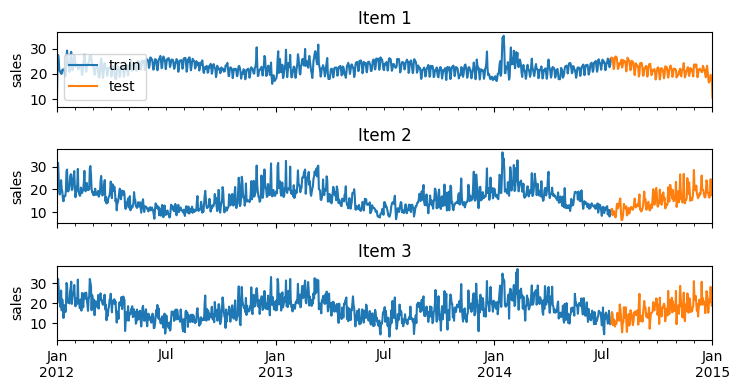

In [19]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7.5, 4), sharex=True)

data_train['item_1'].plot(label='train', ax=axes[0])
data_test['item_1'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('sales')
axes[0].set_title('Item 1')
axes[0].legend()

data_train['item_2'].plot(label='train', ax=axes[1])
data_test['item_2'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('sales')
axes[1].set_title('Item 2')

data_train['item_3'].plot(label='train', ax=axes[2])
data_test['item_3'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('sales')
axes[2].set_title('Item 3')

fig.tight_layout()
plt.show();

### Train 

In [21]:
# Custom function to create features
# ==============================================================================
def create_predictors(y):
    """
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    Calculate the moving standard deviation with window 20.
    Calculate moving minimum and maximum with window 20.
    Calculate exponential moving average with window 20.
    Calculate the difference between the last value and the moving average.
    """

    # Calculate lags
    lags = y[-1:-11:-1]  # window size needed = 10

    # Calculate moving average
    mean = np.mean(y[-20:])  # window size needed = 20

    # Calculate moving standard deviation
    std_dev = np.std(y[-20:])  # window size needed = 20

    # Calculate moving minimum and maximum
    min_val = np.min(y[-20:])
    max_val = np.max(y[-20:])

    # Calculate exponential moving average
    ema = np.mean(y[-20:] * np.exp(-np.linspace(1, 20, 20) / 20))

    # Calculate the difference between the last value and the moving average
    diff_mean = y[-1] - mean

    # Combine all predictors
    predictors = np.hstack([lags, mean, std_dev, min_val, max_val, ema, diff_mean])

    return predictors


feature_names = [f"lag {i}" for i in range(1, 11)] + [
    "moving_avg_20",
    "moving_std_20",
    "moving_min_20",
    "moving_max_20",
    "ema_20",
    "diff_mean",
]

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

The <code>window_size</code> parameter specifies the size of the data window that <code>fun_predictors</code> uses to generate each row of predictors. Choosing the appropriate value for this parameter is crucial to avoid losing data when constructing the training matrices. 
<br><br>
In this case, the <code>window_size</code> required by the <b>mean is the largest</b> (most restrictive), so <code>window_size = 20</code>.

</div>

In [22]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiSeriesCustom(
                 regressor       = RandomForestRegressor(random_state=123),
                 fun_predictors  = create_predictors,
                 name_predictors = feature_names,
                 window_size     = 20 # window_size needed by the mean is the most restrictive one
             )

forecaster.fit(series=data_train)
forecaster

ForecasterAutoregMultiSeriesCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: create_predictors 
Transformer for series: None 
Transformer for exog: None 
Series encoding: ordinal_category 
Window size: 20 
Series levels (names): ['item_1', 'item_2', 'item_3'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: ["'item_1': ['2012-01-01', '2014-07-15']", "'item_2': ['2012-01-01', '2014-07-15']", "'item_3': ['2012-01-01', '2014-07-15']"] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: bootstrap: True, ccp_alpha: 0.0, criterion: squared_error, max_depth: None, max_features: 1.0, ... 
fit_kwargs: {} 
Creation date: 2024-07-13 12:58:10 
Last fit date: 2024-07-13 12:58:50 
Skforecast version: 0.13.0 
Python version: 3.11.9 
Forecaster id: None 

### Predict

If no value is specified for the `levels` argument, predictions will be computed for all available levels.

In [26]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, levels=None)
predictions.head(3)

,item_1,item_2,item_3
2014-07-16,25.821997,11.201055,11.452999
2014-07-17,25.783676,10.794320,12.332219
2014-07-18,25.703845,11.153525,12.552662


### Training matrices

In [27]:
# Training matrix (X)
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(data_train)
X_train.head()

,lag 1,lag 2,lag 3,lag 4,lag 5,lag 6,lag 7,lag 8,lag 9,lag 10,moving_avg_20,moving_std_20,moving_min_20,moving_max_20,ema_20,diff_mean,_level_skforecast
date,,,,,,,,,,,,,,,,,
2012-01-21,24.018768,24.772249,29.245869,26.636444,20.228468,18.976196,20.784194,21.758617,21.751748,21.717691,21.954065,4.161762,8.253175,29.245869,13.267277,2.064703,0
2012-01-22,22.503533,24.018768,24.772249,29.245869,26.636444,20.228468,18.976196,20.784194,21.758617,21.751748,22.666583,2.727996,18.976196,29.245869,13.948776,-0.163050,0
2012-01-23,20.794986,22.503533,24.018768,24.772249,29.245869,26.636444,20.228468,18.976196,20.784194,21.758617,22.567441,2.758017,18.976196,29.245869,13.907556,-1.772455,0
2012-01-24,23.981037,20.794986,22.503533,24.018768,24.772249,29.245869,26.636444,20.228468,18.976196,20.784194,22.389038,2.536512,18.976196,29.245869,13.684263,1.592000,0
2012-01-25,28.018830,23.981037,20.794986,22.503533,24.018768,24.772249,29.245869,26.636444,20.228468,18.976196,22.495203,2.718929,18.976196,29.245869,13.606471,5.523627,0


In [28]:
# Target variable (y)
# ==============================================================================
y_train.head()

date
2012-01-21    22.503533
2012-01-22    20.794986
2012-01-23    23.981037
2012-01-24    28.018830
2012-01-25    28.747482
Name: y, dtype: float64